# Flight Fare Prediction

The flight fare is based on demand and supply model with few restrictions on pricing from regulatory bodies. It is often perceived as unpredictable and recent dynamic pricing scheme added to the confusion. 

The objective is to create a machine learning model for predicting the flight fare based on historical data, which can be used for reference price for customers as well as airline service providers.


**Dataset:**

Dataset can be downloaded from kaggle using the below link:

    https://www.kaggle.com/nikhilmittal/flight-fare-prediction-mh/
    

In [102]:
#importing libraries
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder, RareLabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV


import warnings
warnings.filterwarnings('ignore')

In [103]:
# Importing train data
# Since data is in form of excel file we have to use pandas read_excel to load the data.
# Make sure openpyxl and xlrd are already installed (pip install openpyxl; pip install xlrd) 
df=pd.read_excel('data/Data_Train.xlsx')

In [104]:
# Visualizing the dataframe
df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882


In [105]:
# Exploring the features available in dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [106]:
# Statistical description of the data
df.describe()

,Price
count,10683.000000
mean,9087.064121
std,4611.359167
min,1759.000000
25%,5277.000000
50%,8372.000000
75%,12373.000000
max,79512.000000


In [107]:
df.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [108]:
# Number of rows and columns 
df.shape

(10683, 11)

## Handling Missing values 

In [109]:
# Checking for Missing values 
# df.isna().any()
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

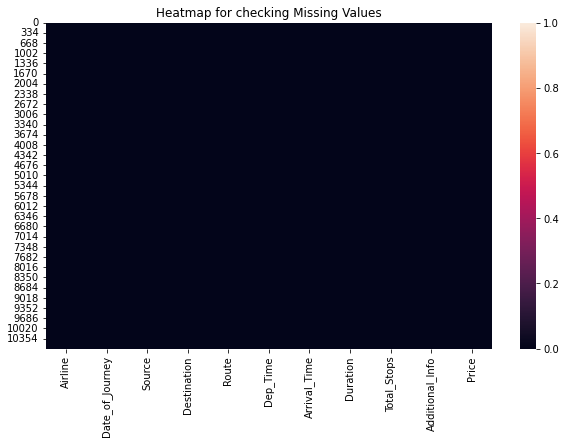

In [110]:
# Visualizing Missing values
plt.figure(figsize=(10,6))
sns.heatmap(df.isna())
plt.title('Heatmap for checking Missing Values')
plt.show()

In [111]:
df[df['Route'].isnull() | df['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [112]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==7480][['Route','Total_Stops']].value_counts()

Route            Total_Stops
DEL → MAA → COK  1 stop         38
DEL → TRV → COK  1 stop          2
dtype: int64

**Either we can fill the Missing value with the most common value as below:**

```
    df['Route'].fillna("DEL → MAA → COK", inplace = True)
    df['Total_Stops'].fillna("1 stop", inplace = True)
```

**OR**

**We can just drop the row with missing value (we can choose this step as there is just 1 row)**


In [113]:
#drop the null values
df.dropna(inplace=True)

In [114]:
#finding the null values
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

In [115]:
# Number of rows and columns 
df.shape

(10682, 11)

## Handling Duplicate values

In [116]:
df.duplicated().any()

True

In [117]:
df[df.duplicated()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
683,Jet Airways,1/06/2019,Delhi,Cochin,DEL → NAG → BOM → COK,14:35,04:25 02 Jun,13h 50m,2 stops,No info,13376
1061,Air India,21/05/2019,Delhi,Cochin,DEL → GOI → BOM → COK,22:00,19:15 22 May,21h 15m,2 stops,No info,10231
1348,Air India,18/05/2019,Delhi,Cochin,DEL → HYD → BOM → COK,17:15,19:15 19 May,26h,2 stops,No info,12392
1418,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,05:30,04:25 07 Jun,22h 55m,2 stops,In-flight meal not included,10368
1674,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,18:25,21:20,2h 55m,non-stop,No info,7303
...,...,...,...,...,...,...,...,...,...,...,...
10594,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,12:35 28 Jun,13h 30m,2 stops,No info,12819
10616,Jet Airways,1/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 02 Jun,26h 55m,2 stops,No info,13014
10634,Jet Airways,6/06/2019,Delhi,Cochin,DEL → JAI → BOM → COK,09:40,12:35 07 Jun,26h 55m,2 stops,In-flight meal not included,11733
10672,Jet Airways,27/06/2019,Delhi,Cochin,DEL → AMD → BOM → COK,23:05,19:00 28 Jun,19h 55m,2 stops,In-flight meal not included,11150


In [118]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==10231][df['Date_of_Journey']=="2019-05-21"]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [119]:
# dropping duplicate values
df.drop_duplicates(inplace=True)

In [120]:
df[df['Airline']=="Air India"][df['Source']=="Delhi"][df['Destination']=="Cochin"][df['Price']==10231][df['Date_of_Journey']=="2019-05-21"]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price


In [121]:
df.duplicated().any()

False

In [122]:
# Number of rows and columns 
df.shape

(10462, 11)

## Performing EDA and Feature Engineering

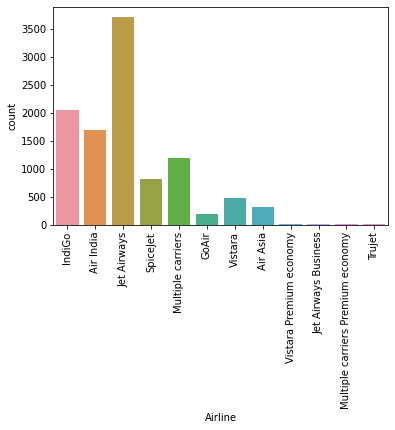

In [123]:
#Now lets check the count of the airlines in the visual graph
plot=plt.figure()
sns.countplot('Airline',data=df)
plt.xticks(rotation=90)
plt.show()

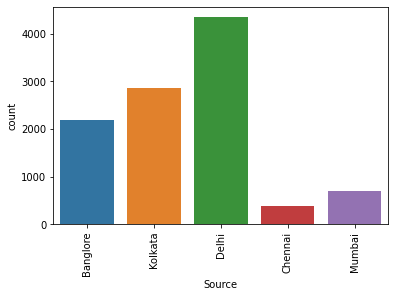

In [124]:
#Now lets check the count of the Source in the visual graph
plot=plt.figure()
sns.countplot('Source',data=df)
plt.xticks(rotation=90)
plt.show()

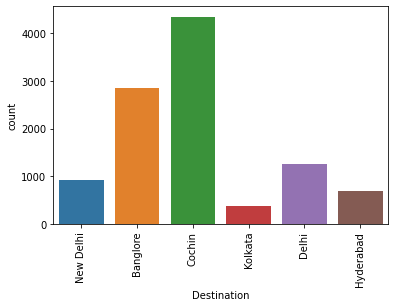

In [125]:
#Now lets check the count of the Destination in the visual graph
plot=plt.figure()
sns.countplot('Destination',data=df)
plt.xticks(rotation=90)
plt.show()

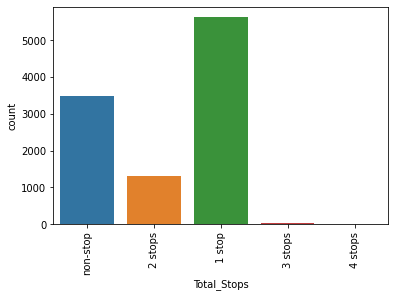

In [126]:
#Now lets check the count of the Total_Stops in the visual graph
plot=plt.figure()
sns.countplot('Total_Stops',data=df)
plt.xticks(rotation=90)
plt.show()

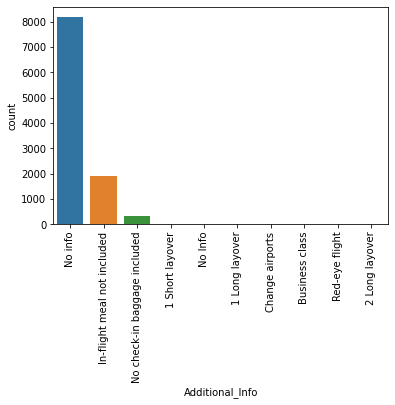

In [127]:
#Now lets check the count of the Additional_info in the visual graph
plot=plt.figure()
sns.countplot('Additional_Info',data=df)
plt.xticks(rotation=90)
plt.show()

In [128]:
#As we can see that there are two 'no_info' columns we combine them
df['Additional_Info']=df['Additional_Info'].str.replace('No info','No Info')

### Extracting useful Features from Date-Time Columns

In [129]:
df['Date_of_Journey']=pd.to_datetime(df['Date_of_Journey'])
df['Dep_Time']=pd.to_datetime(df['Dep_Time']).dt.time
df['Arrival_Time']=pd.to_datetime(df['Arrival_Time']).dt.time

In [130]:
#we are converting the flights day to find which day it is in the week and storing it in the weekday column
df['Journey_Weekday']=df[['Date_of_Journey']].apply(lambda x:x.dt.day_name())

<AxesSubplot:xlabel='Journey_Weekday', ylabel='Price'>

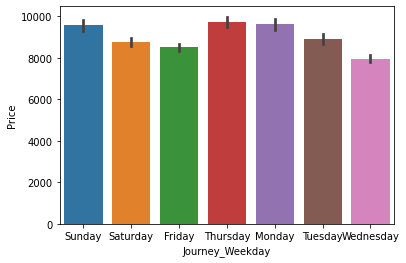

In [131]:
#now lets check the relation between weekday of the journey and the output price column
sns.barplot('Journey_Weekday','Price',data=df)

In [132]:
#we are converting the flights date to find which month it is and storing it in the month column
df["Journey_Month"] = df['Date_of_Journey'].map(lambda x: x.month_name())

<AxesSubplot:xlabel='Journey_Month', ylabel='Price'>

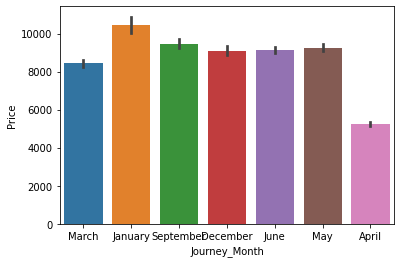

In [133]:
#now lets check the relation between month of journey and the output price column
sns.barplot('Journey_Month','Price',data=df)

In [134]:
#we are converting the flights day to find which day it is in the week and storing it in the weekday column
df['Journey_Day']=df[['Date_of_Journey']].apply(lambda x:x.dt.day)

<AxesSubplot:xlabel='Journey_Day', ylabel='Price'>

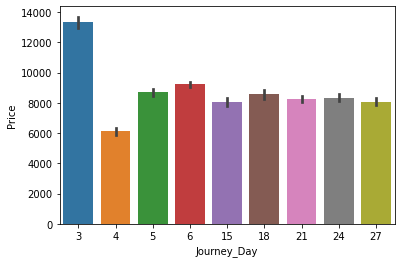

In [135]:
#now lets check the relation between day of the journey and the output price column
sns.barplot('Journey_Day','Price',data=df)

In [136]:
df['Date_of_Journey'].dt.year.value_counts()

2019    10462
Name: Date_of_Journey, dtype: int64

In [137]:
#we are taking the departure time hour column and converting it into a numeric
df['Dep_Hour']=df['Dep_Time'].apply(lambda x:x.hour)
df['Dep_Hour']=pd.to_numeric(df['Dep_Hour'])

<AxesSubplot:xlabel='Dep_Hour', ylabel='Price'>

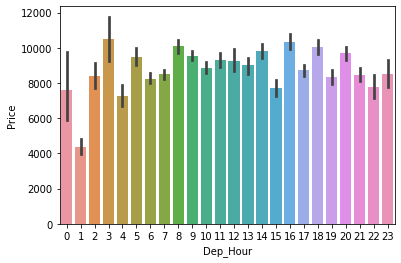

In [138]:
#now lets check the departure time hour relation with the output price column
sns.barplot('Dep_Hour','Price',data=df)

In [139]:
#we are taking the departure time minute column and converting it into a numeric
df['Dep_Min']=df['Dep_Time'].apply(lambda x:x.minute)
df['Dep_Min']=pd.to_numeric(df['Dep_Min'])

In [140]:
#we are taking the arrival time hour column and converting it into a numeric
df['Arrival_Hour']=df['Arrival_Time'].apply(lambda x:x.hour)
df['Arrival_Hour']=pd.to_numeric(df['Arrival_Hour'])

<AxesSubplot:xlabel='Arrival_Hour', ylabel='Price'>

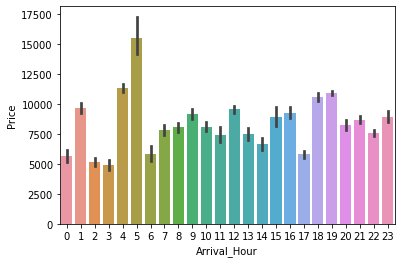

In [141]:
#now lets check the arrival time hour relation with the output price column
sns.barplot('Arrival_Hour','Price',data=df)

In [142]:
#we are taking the arrival time minute column and converting it into a numeric
df['Arrival_Min']=df['Arrival_Time'].apply(lambda x:x.minute)
df['Arrival_Min']=pd.to_numeric(df['Arrival_Min'])

### Extracting useful Features from special column "Routes"

In [143]:
df['Route1']=df['Route'].str.split('→').str[0]
df['Route2']=df['Route'].str.split('→').str[1]
df['Route3']=df['Route'].str.split('→').str[2]
df['Route4']=df['Route'].str.split('→').str[3]
df['Route5']=df['Route'].str.split('→').str[4]
for i in ['Route1','Route2','Route3','Route4','Route5']:
    df[i].fillna('None',inplace=True)

### Handling the unit of measurement 

In [144]:
#For the duration column which is in a hour and min format lets convert it into minutes using a equation 
df['Duration']=df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
#now lets convert this column into a numeric
df['Duration']=pd.to_numeric(df['Duration'])

array([[<AxesSubplot:title={'center':'Duration'}>]], dtype=object)

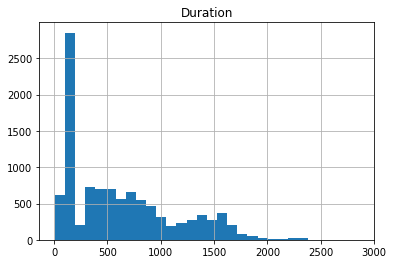

In [145]:
df.hist(column='Duration', bins = 30)

### Removing the irrelevant features

In [146]:
#Now lets remove the irrelevant features
df.drop(['Route','Dep_Time','Arrival_Time','Date_of_Journey'],axis=1,inplace=True)

In [147]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10462 entries, 0 to 10682
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10462 non-null  object
 1   Source           10462 non-null  object
 2   Destination      10462 non-null  object
 3   Duration         10462 non-null  int64 
 4   Total_Stops      10462 non-null  object
 5   Additional_Info  10462 non-null  object
 6   Price            10462 non-null  int64 
 7   Journey_Weekday  10462 non-null  object
 8   Journey_Month    10462 non-null  object
 9   Journey_Day      10462 non-null  int64 
 10  Dep_Hour         10462 non-null  int64 
 11  Dep_Min          10462 non-null  int64 
 12  Arrival_Hour     10462 non-null  int64 
 13  Arrival_Min      10462 non-null  int64 
 14  Route1           10462 non-null  object
 15  Route2           10462 non-null  object
 16  Route3           10462 non-null  object
 17  Route4           10462 non-null

## Handling Outliers

<AxesSubplot:>

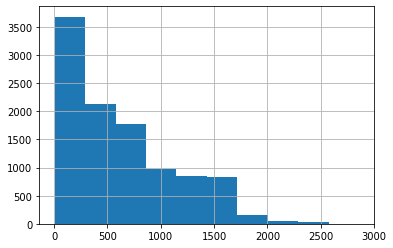

In [148]:
df['Duration'].hist()

<AxesSubplot:xlabel='Duration'>

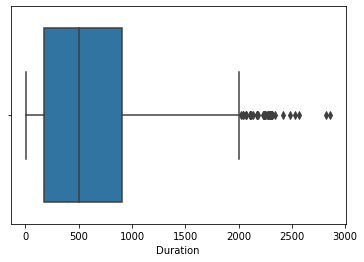

In [149]:
sns.boxplot(df["Duration"])

<AxesSubplot:>

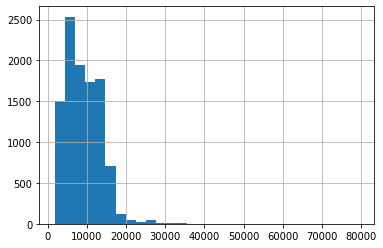

In [150]:
df['Price'].hist(bins=30)

<AxesSubplot:xlabel='Price'>

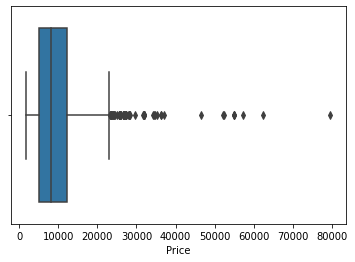

In [151]:
sns.boxplot(df["Price"])

In [152]:
def find_outlier_boundaries(data, variable, distance):
    """
    Calculates the boundaries outside which sit the outliers.
    
    distance passed as an argument, gives us the option to estimate 1.5 times or 3 times the IQR to calculate the boundaries.
    """
    IQR = data[variable].quantile(0.75) - data[variable].quantile(0.25)

    lower_boundary = data[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = data[variable].quantile(0.75) + (IQR * distance)

    return lower_boundary, upper_boundary

In [153]:
# find outlier limits for Price
price_lower_limit, price_upper_limit = find_outlier_boundaries(df, 'Price', 3)
price_lower_limit, price_upper_limit

(-16138.25, 33707.0)

In [154]:
# Now let's replace the outliers by the maximum and minimum limit
df['Price']= np.where(df['Price'] > price_upper_limit, price_upper_limit,
                       np.where(df['Price'] < price_lower_limit, price_lower_limit, df['Price']))

<AxesSubplot:>

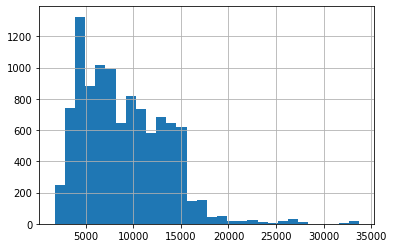

In [155]:
df['Price'].hist(bins=30)

<AxesSubplot:xlabel='Price'>

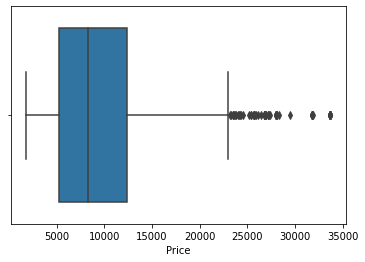

In [156]:
sns.boxplot(df["Price"])

In [157]:
# find outlier limits for Duration
duration_lower_limit, duration_upper_limit = find_outlier_boundaries(df, 'Duration', 3)
duration_lower_limit, duration_upper_limit

(-2050.0, 3130.0)

In [158]:
# Now let's replace the outliers by the maximum and minimum limit
df['Duration']= np.where(df['Duration'] > duration_upper_limit, duration_upper_limit,
                       np.where(df['Duration'] < duration_lower_limit, duration_lower_limit, df['Duration']))

<AxesSubplot:>

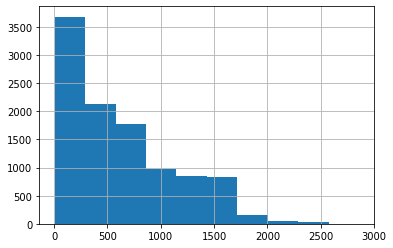

In [159]:
df['Duration'].hist()

<AxesSubplot:xlabel='Duration'>

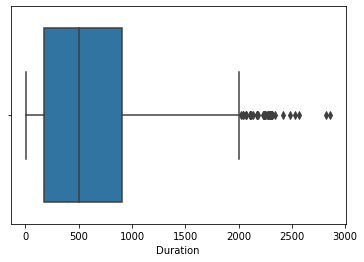

In [160]:
sns.boxplot(df["Duration"])

# Handling Categorical Features

In [161]:
df.columns

Index(['Airline', 'Source', 'Destination', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price', 'Journey_Weekday', 'Journey_Month',
       'Journey_Day', 'Dep_Hour', 'Dep_Min', 'Arrival_Hour', 'Arrival_Min',
       'Route1', 'Route2', 'Route3', 'Route4', 'Route5'],
      dtype='object')

In [212]:
cat_rare_cols = ['Airline', 'Source', 'Destination','Additional_Info', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5']

In [162]:
cat_oh_cols = ['Airline', 'Source', 'Destination','Additional_Info']

In [163]:
cat_le_cols = ['Total_Stops','Journey_Weekday', 'Journey_Month', 'Route1', 'Route2', 'Route3', 'Route4', 'Route5']

In [213]:
X = df.drop('Price',axis=1)
y = df['Price']

In [214]:
# Rare value encoder
rare_encoder = RareLabelEncoder(
    tol=0.05,  # minimal percentage to be considered non-rare
    n_categories=2, # minimal number of categories the variable should have to re-cgroup rare categories
    variables=cat_rare_cols # variables to re-group
)  

X = rare_encoder.fit_transform(X.fillna('Missing'))

In [215]:
ohe_enc = OneHotEncoder(
    top_categories=None,
    variables=cat_oh_cols,  # we can select which variables to encode
    drop_last=True)

X = ohe_enc.fit_transform(X.fillna('Missing'))

In [216]:
ordinal_enc = OrdinalEncoder(
    encoding_method='arbitrary',
    variables=cat_le_cols)

X = ordinal_enc.fit_transform(X.fillna('Missing'))

## Splitting data into train and test sets

In [217]:
# Splitting the data in to two parts one is used to train the model and another is used to evaluate the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [218]:
X_train.shape

(8369, 30)

In [219]:
X_test.shape

(2093, 30)

## Standardization

In [220]:
scaler = StandardScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Checking the importance of Features

In [221]:
imp = pd.DataFrame(mutual_info_classif(X_train_scaled,y_train),index=X_train.columns)

In [222]:
imp.columns=['importance']
imp.sort_values(by='importance',ascending=False)

,importance
Route2,2.849226
Route1,2.724031
Route3,2.678286
Total_Stops,2.311808
Duration,2.186893
Airline_Jet Airways,2.132115
Source_Delhi,2.124513
Source_Kolkata,2.113361
Destination_Cochin,2.084752
Additional_Info_In-flight meal not included,2.081597


## Training and Evaluating Models

In [223]:
def model_eval(trained_model):
    print("Training score: {}".format(trained_model.score(X_train_scaled,y_train)))
    print("Testing score: {}".format(trained_model.score(X_test_scaled,y_test)))
    test_predictions = trained_model.predict(X_test_scaled)
    print('MAE:{}'.format(mean_absolute_error(y_test,test_predictions)))
    print('MSE:{}'.format(mean_squared_error(y_test,test_predictions)))
    print('RMSE:{}'.format(np.sqrt(mean_squared_error(y_test,test_predictions))))
    plt.hist(y_test-test_predictions, bins=30)

In [224]:
def train_n_eval(ml_model):
    print('Model is: {}'.format(ml_model))
    model= ml_model.fit(X_train_scaled,y_train)
    model_eval(model)


Model is: LinearRegression()
Training score: 0.6525890161477207
Testing score: 0.6546919759913734
MAE:1810.3873913438508
MSE:6441244.782862914
RMSE:2537.9607528216256


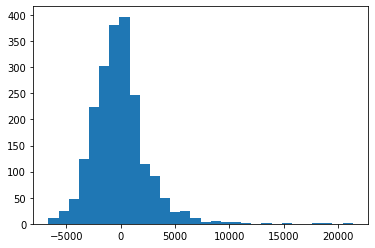

In [225]:
train_n_eval(LinearRegression())

Model is: KNeighborsRegressor()
Training score: 0.8702461750231574
Testing score: 0.8170917275640103
MAE:1108.6414715719063
MSE:3411901.472470139
RMSE:1847.1333120460308


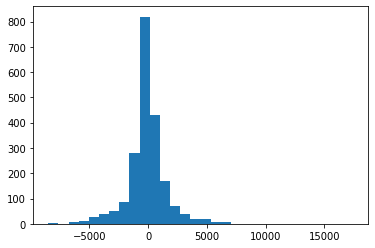

In [226]:
train_n_eval(KNeighborsRegressor())

Model is: DecisionTreeRegressor()
Training score: 0.9954914632600314
Testing score: 0.8608065979313304
MAE:725.8182035355949
MSE:2596460.877090301
RMSE:1611.3537405207774


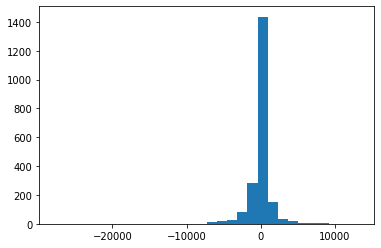

In [227]:
train_n_eval(DecisionTreeRegressor())

Model is: RandomForestRegressor()
Training score: 0.9840629529755546
Testing score: 0.918796408861503
MAE:633.3994541972864
MSE:1514740.9599653827
RMSE:1230.7481301896755


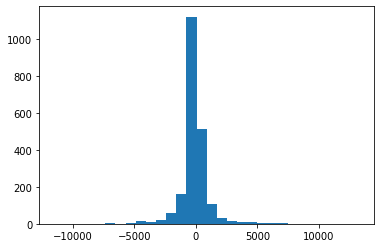

In [228]:
train_n_eval(RandomForestRegressor())

Model is: GradientBoostingRegressor()
Training score: 0.8456571874579576
Testing score: 0.8319473406701816
MAE:1171.5255597918622
MSE:3134790.505555668
RMSE:1770.5339605767713


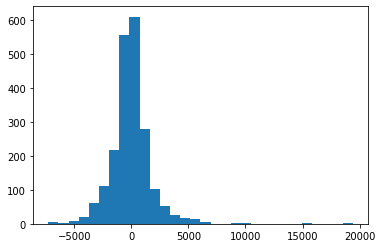

In [229]:
train_n_eval(GradientBoostingRegressor())

In [230]:
regg=[LinearRegression(),KNeighborsRegressor(),DecisionTreeRegressor(),RandomForestRegressor(),GradientBoostingRegressor()]

In [231]:
for i in regg:
    cvs=cross_val_score(i,X_train_scaled,y_train,cv=5,scoring=make_scorer(r2_score))
    print(i.__class__.__name__, ': ', np.mean(cvs))

LinearRegression :  0.6488674779970275
KNeighborsRegressor :  0.7910499937651718
DecisionTreeRegressor :  0.8365502452644711
RandomForestRegressor :  0.9068035572603425
GradientBoostingRegressor :  0.8362005477334801


## Hyperparameter Tuning ( Randomized Search CV)

In [232]:
n_estimators=[int(x) for x in np.linspace(start=50, stop=250, num=10)]
max_features=['auto','sqrt']
max_depth=[int(x) for x in np.linspace(5,30,num=10)]
min_samples_leaf=[1,2,5,10]

In [233]:
random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_leaf':min_samples_leaf
}

In [234]:
reg_rf = RandomForestRegressor()

scoring options:

['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted']

In [235]:
rf_random=RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, 
                              scoring='r2',
                              n_iter=10, cv=5,random_state=101,n_jobs=1)

In [236]:
rf_random.fit(X_train_scaled,y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 7, 10, 13, 16, 18, 21,
                                                      24, 27, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'n_estimators': [50, 72, 94, 116, 138,
                                                         161, 183, 205, 227,
                                                         250]},
                   random_state=101, scoring='r2')

In [237]:
rf_random.best_params_

{'n_estimators': 227,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 24}

Training score: 0.9844967207504716
Testing score: 0.9190250384327405
MAE:633.6877000971537
MSE:1510476.190743266
RMSE:1229.0143167364918


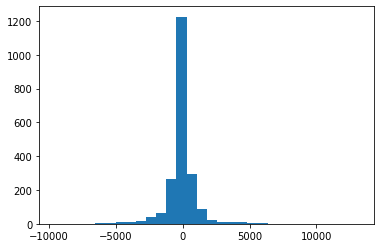

In [238]:
model_eval(rf_random)

# Predicting for test data file¶

In [239]:
test_df=pd.read_excel('data/Test_set.xlsx')

In [240]:
test_df.head(3)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info
0,Jet Airways,6/06/2019,Delhi,Cochin,DEL → BOM → COK,17:30,04:25 07 Jun,10h 55m,1 stop,No info
1,IndiGo,12/05/2019,Kolkata,Banglore,CCU → MAA → BLR,06:20,10:20,4h,1 stop,No info
2,Jet Airways,21/05/2019,Delhi,Cochin,DEL → BOM → COK,19:15,19:00 22 May,23h 45m,1 stop,In-flight meal not included


In [241]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2671 entries, 0 to 2670
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          2671 non-null   object
 1   Date_of_Journey  2671 non-null   object
 2   Source           2671 non-null   object
 3   Destination      2671 non-null   object
 4   Route            2671 non-null   object
 5   Dep_Time         2671 non-null   object
 6   Arrival_Time     2671 non-null   object
 7   Duration         2671 non-null   object
 8   Total_Stops      2671 non-null   object
 9   Additional_Info  2671 non-null   object
dtypes: object(10)
memory usage: 208.8+ KB


In [242]:
test_df.isna().any()

Airline            False
Date_of_Journey    False
Source             False
Destination        False
Route              False
Dep_Time           False
Arrival_Time       False
Duration           False
Total_Stops        False
Additional_Info    False
dtype: bool

In [243]:
test_df['Date_of_Journey']=pd.to_datetime(test_df['Date_of_Journey'])
test_df['Dep_Time']=pd.to_datetime(test_df['Dep_Time']).dt.time
test_df['Arrival_Time']=pd.to_datetime(test_df['Arrival_Time']).dt.time
test_df['Additional_Info']=test_df['Additional_Info'].str.replace('No info','No Info')
test_df['Journey_Weekday']=test_df[['Date_of_Journey']].apply(lambda x:x.dt.day_name())
test_df["Journey_Month"] = test_df['Date_of_Journey'].map(lambda x: x.month_name())
test_df['Journey_Day']=test_df[['Date_of_Journey']].apply(lambda x:x.dt.day)
test_df['Dep_Hour']=pd.to_numeric(test_df['Dep_Time'].apply(lambda x:x.hour))
test_df['Dep_Min']=pd.to_numeric(test_df['Dep_Time'].apply(lambda x:x.minute))
test_df['Arrival_Hour']=pd.to_numeric(test_df['Arrival_Time'].apply(lambda x:x.hour))
test_df['Arrival_Min']=pd.to_numeric(test_df['Arrival_Time'].apply(lambda x:x.minute))
test_df['Route1']=test_df['Route'].str.split('→').str[0]
test_df['Route2']=test_df['Route'].str.split('→').str[1]
test_df['Route3']=test_df['Route'].str.split('→').str[2]
test_df['Route4']=test_df['Route'].str.split('→').str[3]
test_df['Route5']=test_df['Route'].str.split('→').str[4]
for i in ['Route1','Route2','Route3','Route4','Route5']:
    test_df[i].fillna('None',inplace=True)
test_df['Duration']=test_df['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)
test_df['Duration']=pd.to_numeric(test_df['Duration'])
test_df.drop(['Route','Dep_Time','Arrival_Time','Date_of_Journey'],axis=1,inplace=True)


In [244]:
test_df.shape

(2671, 18)

In [246]:
test_df = rare_encoder.transform(test_df.fillna('Missing'))
test_df = ohe_enc.transform(test_df.fillna('Missing'))
test_df = ordinal_enc.transform(test_df.fillna('Missing'))

In [249]:
test_df_scaled = scaler.transform(test_df)

In [250]:
test_df_predictions = rf_random.predict(test_df_scaled)
test_df_predictions

array([14710.3215859 ,  4289.91189427, 12898.        , ...,
       16675.53303965, 13674.48017621,  7547.35682819])